In [4]:
import scipy.stats as stats
import xarray
import numpy as np
import pandas as pd
import xarray
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
import mapleaflet

ModuleNotFoundError: No module named 'mapleaflet'

finish month
finish average
finish std


/tmp/ipykernel_948100/3359437805.py:35: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


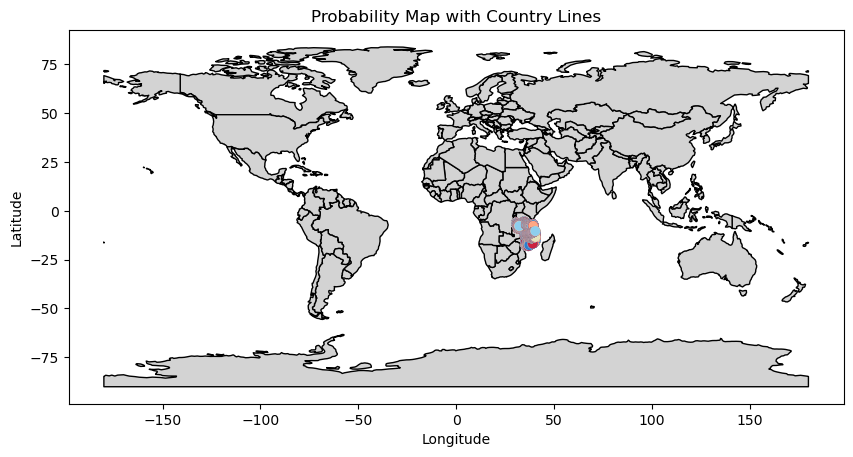

In [3]:
#with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#    average_data = xarray.open_mfdataset("/Users/rachel1/downloads/vpu_101/combined_all_data_101.nc")
 #   monthly_data = xarray.open_mfdataset("/Users/rachel1/downloads/vpu_101/combined_monthly_data.nc")

month_num = 1
year_num = 2010

all_data = xarray.open_dataset("workspaces/app_workspace/combined_all_data_101.nc")
monthly_data = xarray.open_dataset("workspaces/app_workspace/combined_monthly_data.nc")
# Filter data directly in xarray
filtered_data = all_data["ds_grouped_avg"].sel(
    variable="Qout",
    time=(all_data["ds_grouped_avg"]["time"].dt.month == month_num) &
         (all_data["ds_grouped_avg"]["time"].dt.year == year_num)
)

# Convert the filtered data to a DataFrame
month_df = filtered_data.to_dataframe().reset_index()
print("finish month")
average_df = monthly_data["monthly_average"].to_dataframe().reset_index()
average_df = average_df[(average_df["variable"] == "Qout") & (average_df["month"] == month_num)]
print("finish average")
std_df = monthly_data["monthly_std_dev"].to_dataframe().reset_index()
std_df = std_df[(std_df["variable"] == "Qout") & (std_df["month"] == month_num)]
print("finish std")
merged_df = month_df.merge(average_df[['rivid', 'monthly_average']], on='rivid', how='left')
merged_df = merged_df.merge(std_df[['rivid', 'monthly_std_dev']], on='rivid', how='left')

# Calculate Z-score for ds_grouped_avg using mean and standard deviation
merged_df['z_score'] = (merged_df['ds_grouped_avg'] - merged_df['monthly_average']) / merged_df['monthly_std_dev']

# Calculate exceedance probability using the cumulative distribution function (CDF)
merged_df['probability'] = stats.norm.cdf(merged_df['z_score'])
# Load a shapefile with country boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Assuming 'merged_df' is your DataFrame
# Replace 'lat', 'lon', and 'exceedance_probability' with your actual column names

# Define the categories and corresponding colors
categories = ["extremely dry", "dry", "Normal range", "wet", "extremely wet"]
colors = ["#CD233F", "#FFA885", "#E7E2BC", "#8ECEEE", "#2C7DCD"]

# Map the exceedance_probability values to categories
merged_df['category'] = np.select(
    [merged_df['probability'] >= 0.87,
     (merged_df['probability'] >= 0.72) & (merged_df['probability'] < 0.87),
     (merged_df['probability'] >= 0.28) & (merged_df['probability'] < 0.72),
     (merged_df['probability'] >= 0.13) & (merged_df['probability'] < 0.28),
     merged_df['probability'] < 0.13],
    categories, default="unknown"
)

# Create a custom colormap
cmap = ListedColormap(colors)

# Create a GeoDataFrame from the DataFrame with lat, lon
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.lon, merged_df.lat))

# Plot the world map
ax = world.plot(figsize=(10, 6), color='lightgray', edgecolor='black')

# Plot the scatter plot with color-coded points using the custom colormap
scatter = gdf.plot(ax=ax, c=gdf['category'].map({category: i for i, category in enumerate(categories)}), cmap=cmap, legend=False)

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Probability Map with Country Lines')

# Show the plot
plt.show()

# Convert Matplotlib plot to a zoomable Leaflet map
mplleaflet.display(fig=ax.figure, crs=gdf.crs)